# Instance Segmentation On Flickr_Data

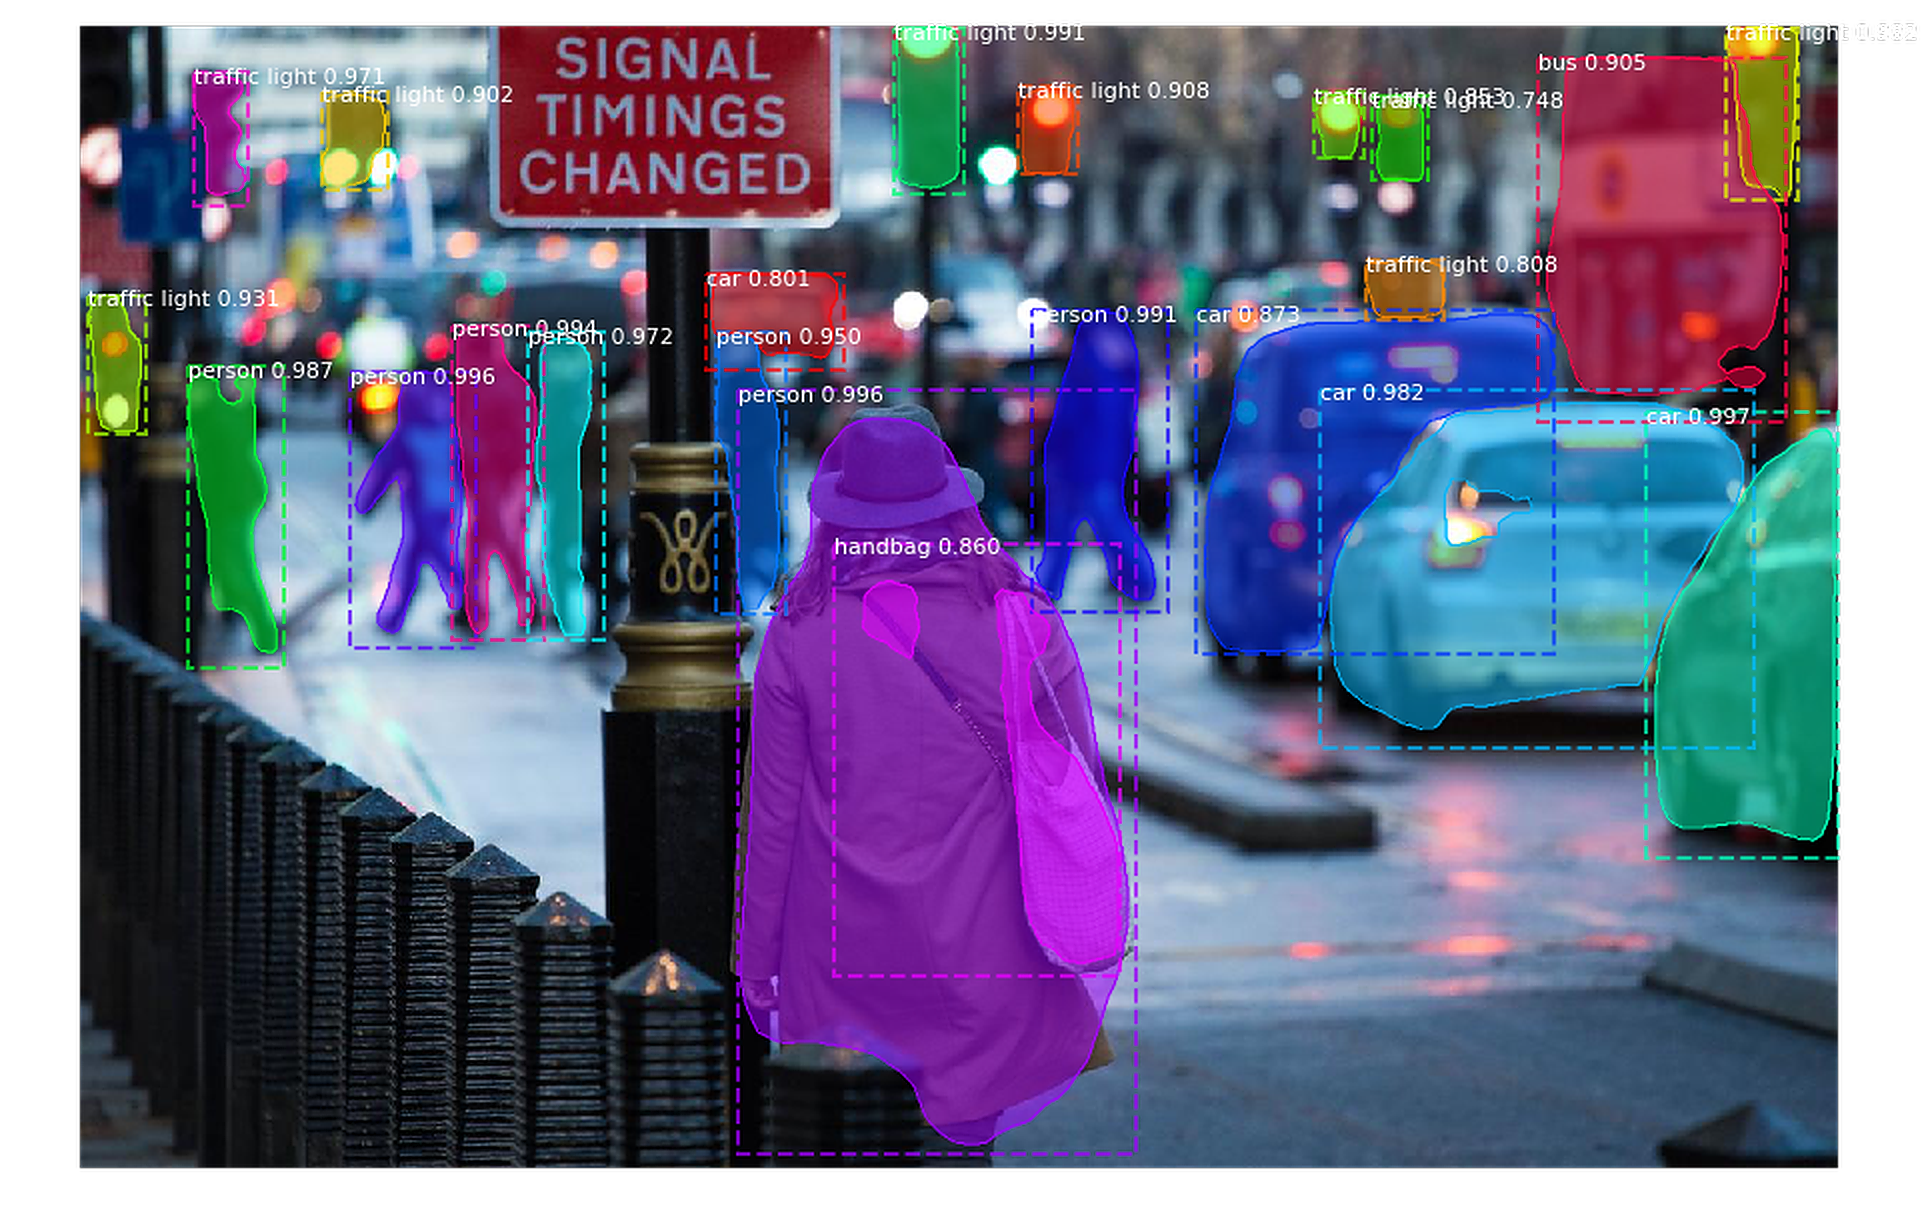

In [2]:
from IPython.display import Image
Image(filename='im.png') 

# Data description
Flicker8k_Dataset: Contains 8092 photographs in jpeg format.

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


First, we will clone the mask rcnn repository which has the architecture for Mask R-CNN. Use the following command to clone the repository

In [0]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 31.59 MiB/s, done.
Resolving deltas: 100% (569/569), done.


change the working directory to Mask_RCNN

In [0]:
import os
os.chdir('./Mask_RCNN')

download the data on which prediction is to be made(Flickr_data)

In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!pip install -q kaggle

In [0]:
! kaggle datasets download -d shadabhussain/flickr8k

 99% 2.11G/2.13G [00:13<00:00, 193MB/s]
100% 2.13G/2.13G [00:13<00:00, 167MB/s]


In [0]:
! unzip flickr8k.zip

In [0]:
!ls

assets	Images	 MANIFEST.in  README.md		samples    setup.py
images	LICENSE  mrcnn	      requirements.txt	setup.cfg


import the required libraries and define the path for the pretrained weights and the images on which we would like to perform segmentation

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

from mrcnn import utils
from samples.coco import coco
import mrcnn.model as modellib
from mrcnn import visualize


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "Images")

Using TensorFlow backend.


... done downloading pretrained model!


Create an inference class which will be used to infer the Mask R-CNN model

In [0]:
class InferenceConfig(coco.CocoConfig):
    """
    Set batch size to 1 since we'll be running inference on
    one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Next, we will create our model and load the pretrained weights which we downloaded earlier

In [0]:
""" Create model object in inference mode """

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)


define the classes of the COCO dataset which will help us in the prediction phase:

In [0]:
# COCO Class names
"""
Index of the class in the list is its ID. For example, to get ID of
the car class, use: class_names.index('car')
"""

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

We will use the Mask R-CNN model along with the pretrained weights and see how well it segments the object.

Processing 1 images
image                    shape: (500, 333, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


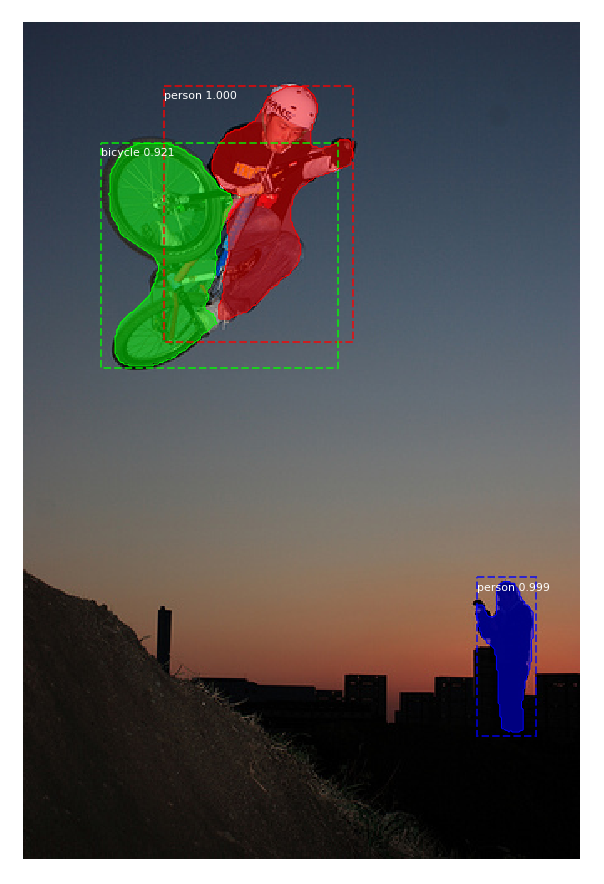

In [0]:
#Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

"""
model.detect function is used
to detect the class labels in the imges
"""

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (500, 375, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


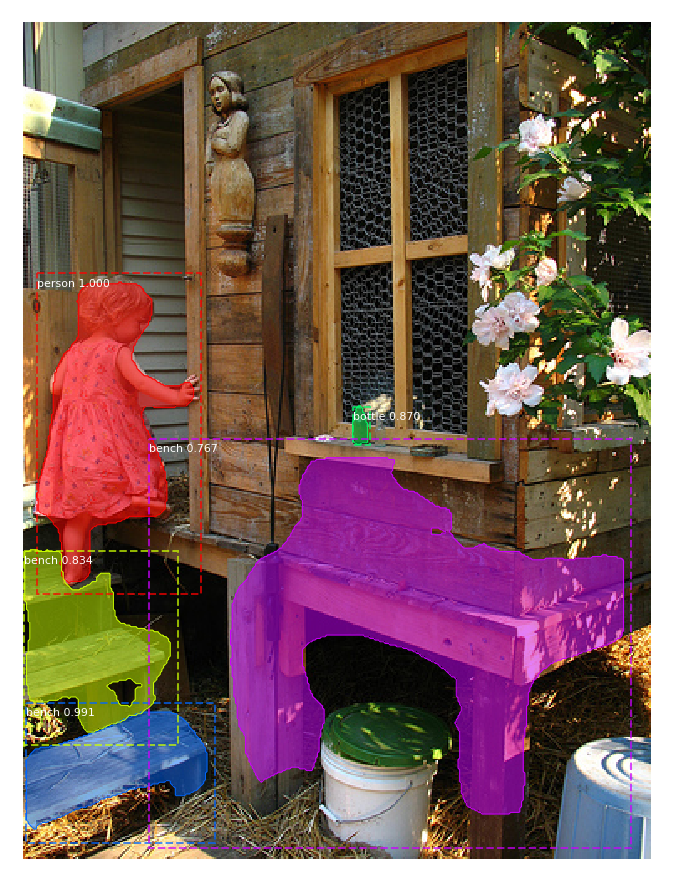

In [0]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR,'1000268201_693b08cb0e.jpg'))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (500, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


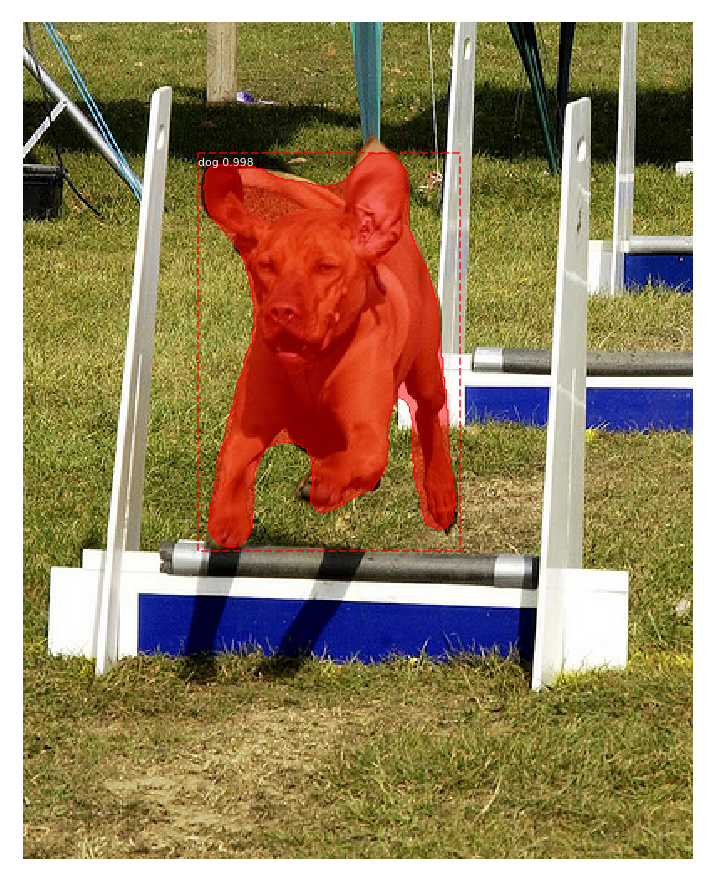

In [0]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR,random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [0]:
#make the videos directory
!mkdir videos

make the movie out of the images present in the flickr_data

In [0]:
#https://gist.github.com/ch3ll0v3k/c3a2e3827bae83f9a79421d6abba7458
import sys
import cv2  
from PIL import Image  

video_name = 'videos/Video.mp4'
image_folder = 'Images'
fps = 10

def generate_video(): 

    # os.chdir( global_path ); 
      
    images = [img for img in os.listdir(image_folder) 
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")] 

    # exit();

    images.sort();
    # print(images);

    frame = cv2.imread(os.path.join(image_folder, images[0])) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(video_name, 0, fps, (width, height));
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
    print(' Done ...');
  
  
# Calling the generate_video function 
generate_video() 

 Done ...


In [0]:
!ls ./videos

videos.mp4


now from the movie,take 3 images at the time and make prediction on it and save it the desired folder.

In [0]:
import cv2
import numpy as np


def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image


if __name__ == '__main__':
    """
        test everything
    """
    
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size =3

    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'videos.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

finding the frame per second in the movies

In [0]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'videos.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release()

Frames per second using video.get(cv2.CAP_PROP_FPS) : 10.0


form the video out of the images on which we have applied mask rcnn

In [0]:
def make_video(outvid, images=None, fps=10, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR = os.getcwd()
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
make_video(outvid, images, fps=30)

<VideoWriter 0x7ff6ebd698f0>

download the video

In [0]:
from google.colab import files
files.download('videos/out.mp4')

[output video link](https://imgur.com/a/2NuPZpM)

***Steps used-***

1-Clone the respository(git clone https://github.com/matterport/Mask_RCNN.git)

2-change the working directory to Mask_RCNN

3-download the data on which prediction is to be made(Flickr_data)

4-import the required libraries and define the path for the pretrained weights and the images on which we would like to perform segmentation.

5-Create an inference class which will be used to infer the Mask R-CNN model

6-Next, we will create our model and load the pretrained weights which we downloaded earlier

7-define the classes of the COCO dataset which will help us in the prediction phase

8-We will use the Mask R-CNN model along with the pretrained weights and segments the object.

9-make the movie out of the images present in the flickr_data

10-now from the movie,take 3 images at the time and make prediction on it and save it the desired folder.

11-form the video out of the images on which we have applied mask rcnn 

12-download the output video.

Reference-

https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/